In [1]:
import numpy as np

np.set_printoptions(
    suppress=True,
    linewidth=180
)

In [2]:
from typing import List, Optional
import random

class Vulnerability:
    id: int
    attackerCost: int
    defenderCost: int
    attackerProb: float
    defenderProb: float
    severity: int
    def __init__(
        self,
        id: int,
        acost: Optional[int] = None,
        dcost: Optional[int] = None,
        aprob: Optional[float] = None,
        dprob: Optional[float] = None,
        sev: Optional[int] = None
    ) -> None:
        self.id = id
        if acost is None: acost = random.randint(1,5)
        if dcost is None: dcost = random.randint(1,5)
        if aprob is None: aprob = round(random.uniform(0.05,0.98),2)
        if dprob is None: dprob = round(random.uniform(0.8,0.98),2)
        if sev is None: sev = random.randint(1,5)
        self.attackerCost = acost
        self.defenderCost = dcost
        self.attackerProb = aprob
        self.defenderProb = dprob
        self.severity = sev
    def __str__(self) -> str:
        return f"Action(id={self.id}, acost={self.attackerCost}, dcost={self.defenderCost}, aprob={self.attackerProb}, dprob={self.defenderProb}, sev={self.severity})"
    def __repr__(self) -> str:
        return self.__str__()

class Vehicle:
    vulns: List[Vulnerability]
    def __init__(self, num_vulns: int) -> None:
        self.vulns = [Vulnerability(x) for x in range(num_vulns)]
    def __str__(self) -> str:
        return f"Vehicle(num_vulns={len(self.vulns)})"
    def __repr__(self) -> str:
        return self.__str__()


In [3]:
from typing import TypeVar


T = TypeVar("T")
def powerset(s: List[T]) -> List[List[T]]:
    import itertools
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [4]:
def get_attacker_utility(
    defending: List[Vulnerability],
    attacking: List[Vulnerability]
) -> float:
    defendingLookup = set([x.id for x in defending])
    rtn = 0
    for v in attacking:
        if v.id in defendingLookup:
            rtn += v.severity ** 2 * v.attackerProb * (1-v.defenderProb)
        else:
            rtn += v.severity ** 2 * v.attackerProb
    return rtn


In [5]:
class SubgameSolution:
    defender_util: int
    severity_chances: List[float]
    dchoice: List[Vehicle]
    achoice: List[Vehicle]
    def __init__(self, dchoice: List[Vulnerability], achoice: List[Vulnerability]) -> None:
        self.dchoice = dchoice
        self.achoice = achoice
        self.defender_util = round(-get_attacker_utility(dchoice, achoice),2)
        # Start off as the chance that it is not compromised
        self.severity_chances = {
            1:1,
            2:1,
            3:1,
            4:1,
            5:1
        }
        defendingLookup = set([x.id for x in dchoice])
        for vuln in achoice:
            # Decrease the chance it is not compromised by the chance the attacks fail
            if vuln.id in defendingLookup:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb * (1-vuln.defenderProb))
            else:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb)

        # Convert to the chance that a compromise with the given severity is _successful_
        for k in self.severity_chances.keys():
            self.severity_chances[k] = round(1 - self.severity_chances[k],2)
    # def to_json(self):
    #     import json
    #     return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [6]:
from typing import Tuple

def get_optimal_actions(
    vehicle: Vehicle,
    attacker_cost_available: int,
    defender_cost_available: int,
) -> SubgameSolution:
    subsets = list(powerset(vehicle.vulns))

    best_defender_util = -1e100
    best_defender_subset = None
    best_attacker_subset = None
    for dchoice in subsets:
        if sum([x.defenderCost for x in dchoice]) > defender_cost_available: continue
        temp_best_attacker_util = 0
        temp_best_attacker_subset = None
        for achoice in subsets:
            if sum([x.attackerCost for x in achoice]) > attacker_cost_available: continue
            attacker_util = get_attacker_utility(dchoice, achoice)
            if attacker_util > temp_best_attacker_util:
                temp_best_attacker_util = attacker_util
                temp_best_attacker_subset = achoice
        if temp_best_attacker_util * -1 > best_defender_util:
            # Defender util is negative attacker util
            # Defender wants to minimize best attacker utility
            best_defender_util = -1 * temp_best_attacker_util
            best_defender_subset = dchoice
            best_attacker_subset = temp_best_attacker_subset
    return SubgameSolution(best_defender_subset, best_attacker_subset)

In [17]:
x = Vehicle(15)

In [20]:
i = 0
for _ in powerset(x.vulns):
    i += 1
print(i)
print(i*i)

32767
1073676289


In [14]:
soln = get_optimal_actions(x, 10, 10)
print(soln.defender_util)
print(soln.severity_chances)
print(soln.dchoice)
print(soln.achoice)

-37.12
{1: 0, 2: 0.34, 3: 0.36, 4: 0.65, 5: 0.78}
(Action(id=2, acost=3, dcost=3, aprob=0.59, dprob=0.91, sev=5), Action(id=6, acost=4, dcost=1, aprob=0.5, dprob=0.83, sev=5), Action(id=8, acost=2, dcost=3, aprob=0.9, dprob=0.85, sev=5), Action(id=11, acost=5, dcost=2, aprob=0.83, dprob=0.96, sev=5), Action(id=13, acost=2, dcost=1, aprob=0.82, dprob=0.91, sev=3))
(Action(id=0, acost=1, dcost=4, aprob=0.65, dprob=0.95, sev=4), Action(id=8, acost=2, dcost=3, aprob=0.9, dprob=0.85, sev=5), Action(id=9, acost=1, dcost=1, aprob=0.36, dprob=0.95, sev=3), Action(id=10, acost=1, dcost=1, aprob=0.34, dprob=0.9, sev=2), Action(id=14, acost=5, dcost=5, aprob=0.75, dprob=0.96, sev=5))


In [22]:
list(powerset([1,2,3,4,5,6]))

[(1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (1, 5, 6),
 (2, 3, 4),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6),
 (2, 5, 6),
 (3, 4, 5),
 (3, 4, 6),
 (3, 5, 6),
 (4, 5, 6),
 (1, 2, 3, 4),
 (1, 2, 3, 5),
 (1, 2, 3, 6),
 (1, 2, 4, 5),
 (1, 2, 4, 6),
 (1, 2, 5, 6),
 (1, 3, 4, 5),
 (1, 3, 4, 6),
 (1, 3, 5, 6),
 (1, 4, 5, 6),
 (2, 3, 4, 5),
 (2, 3, 4, 6),
 (2, 3, 5, 6),
 (2, 4, 5, 6),
 (3, 4, 5, 6),
 (1, 2, 3, 4, 5),
 (1, 2, 3, 4, 6),
 (1, 2, 3, 5, 6),
 (1, 2, 4, 5, 6),
 (1, 3, 4, 5, 6),
 (2, 3, 4, 5, 6),
 (1, 2, 3, 4, 5, 6)]

In [63]:
solutions: List[SubgameSolution] = []

In [64]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

for i in tqdm(range(1000 - len(solutions))):
    s = get_optimal_actions(Vehicle(8), 10, 10)
    solutions.append(s)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [69]:
solutions = sorted(solutions, key=lambda x: x.defender_util)
for s in solutions:
    print(s.defender_util, s.severity_chances)

-36.26 {1: 0, 2: 0, 3: 0.49, 4: 0.81, 5: 0.57}
-36.02 {1: 0, 2: 0, 3: 0.85, 4: 0.68, 5: 0.66}
-33.69 {1: 0, 2: 0, 3: 0, 4: 0.64, 5: 0.79}
-33.2 {1: 0, 2: 0.47, 3: 0, 4: 0.59, 5: 0.79}
-32.3 {1: 0, 2: 0, 3: 0.9, 4: 0.49, 5: 0.63}
-31.59 {1: 0, 2: 0.76, 3: 0, 4: 0.97, 5: 0.16}
-31.13 {1: 0, 2: 0.9, 3: 0.75, 4: 0.88, 5: 0.18}
-30.68 {1: 0, 2: 0, 3: 0, 4: 0.78, 5: 0.6}
-28.27 {1: 0, 2: 0, 3: 0.52, 4: 0.74, 5: 0.47}
-28.19 {1: 0, 2: 0.62, 3: 0, 4: 0.71, 5: 0.46}
-28.12 {1: 0.96, 2: 0, 3: 0, 4: 0.79, 5: 0.49}
-27.03 {1: 0, 2: 0, 3: 0.16, 4: 0.37, 5: 0.69}
-26.87 {1: 0, 2: 0, 3: 0.92, 4: 0, 5: 0.56}
-26.05 {1: 0, 2: 0, 3: 0.87, 4: 0.88, 5: 0}
-25.8 {1: 0, 2: 0.45, 3: 0.58, 4: 0, 5: 0.67}
-25.64 {1: 0, 2: 0, 3: 0.36, 4: 0.91, 5: 0}
-25.59 {1: 0, 2: 0.28, 3: 0, 4: 0.57, 5: 0.57}
-25.56 {1: 0, 2: 0, 3: 0, 4: 0.38, 5: 0.64}
-25.56 {1: 0.29, 2: 0, 3: 0, 4: 0.52, 5: 0.57}
-25.5 {1: 0, 2: 0, 3: 0, 4: 0.91, 5: 0.11}
-24.95 {1: 0, 2: 0, 3: 0.89, 4: 0.84, 5: 0.07}
-24.88 {1: 0, 2: 0.84, 3: 0.12, 4: 0.8

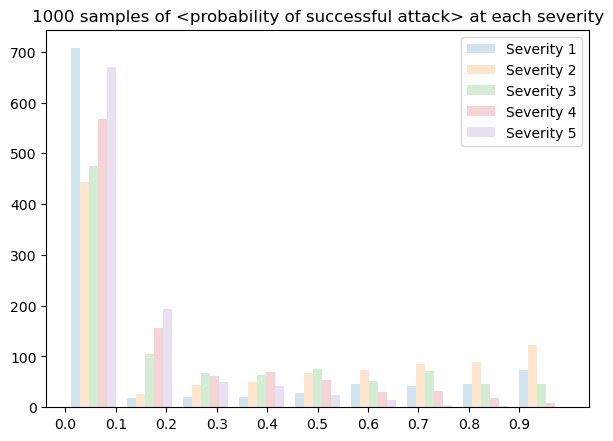

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"figure.figsize":(7,5), "figure.dpi":100})

bins = np.linspace(0,1,10)

plt.hist([[s.severity_chances[i] for s in solutions] for i in range(1,6)], bins, alpha=0.2, label=[f"Severity {i}" for i in range(1,6)])
# plt.hist(human, bins, alpha=0.5, label="human")
# plt.hist(ai, bins, alpha=0.5, label="ai")
plt.xticks(np.arange(0,1,0.1))
plt.legend(loc="upper right")
plt.title(f"{len(solutions)} samples of <probability of successful attack> at each severity")
plt.show()
# plt.gca().set(title="Freq histogram", ylabel="Freq")

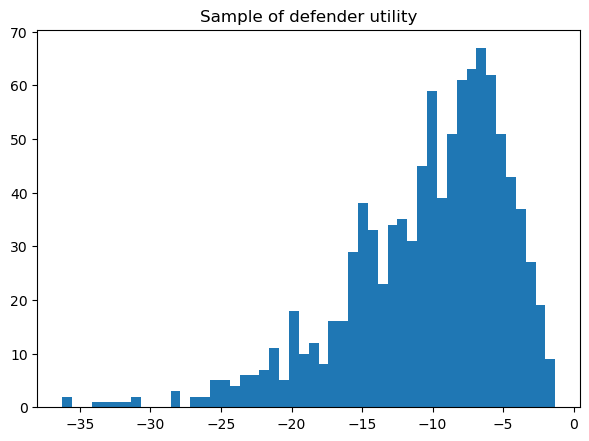

In [71]:
plt.hist([s.defender_util for s in solutions], bins=50)
plt.title("Sample of defender utility")
plt.show()

In [72]:
import json
# def _default(self, obj):
#     return getattr(obj, "to_json", _default.default)(obj)
# _default.default = json.JSONEncoder().default
# json.JSONEncoder.default = _default
with open("solutions.json","w") as f:
    json.dump(solutions, f, default=vars)